In [1]:
import zipfile, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functions.functions import previous_yrs, opponent_stats

# Read in files

In [2]:
_file = os.path.join('Data', 'finalgamedata.zip')
zf = zipfile.ZipFile(_file)
gamestats = pd.read_csv(zf.open('gamestats.csv'))
gamelist = pd.read_csv(zf.open('gameslist.csv'))
gamelist['opponentName'] = gamelist['opponentName'].str.replace("  ", " ")

In [3]:
gamestats.TOP = pd.to_timedelta(gamestats.TOP).astype('timedelta64[s]')

In [4]:
# Create a list of the teams 
teamlist = list(gamelist['Team'].unique())

In [5]:
# Create the opponent's game list data for use later 
opponent_game_list_data = gamelist.copy(deep=True)
opponent_game_list_data.drop(['Opponent', 'Result', 'year', 'opponentName'], axis = 1, inplace = True)
opponent_game_list_data.rename(columns={'Team':'opponentName'}, inplace = True)
# Relabel the variables
opponent_game_list_columns = ['opp_'+ x if x not in ['Date', 'opponentName']
                              else x
                              for x in list(opponent_game_list_data.columns) 
                             ]

opponent_game_list_data.columns = opponent_game_list_columns

In [6]:
gamelist = gamelist.merge(opponent_game_list_data, 
                          left_on = ['opponentName', 'Date'],
                          right_on = ['opponentName', 'Date'], 
                          how = 'left'
                         );

# Target variables

In [7]:
target_variables = ["FG","RushNetYards","PassYards","Interceptions","Pct", "RZScores",
                    "Punts","FumblesLost","Penalties","Plays","def_RushNetYards","def_PassYards",
                    "def_Interceptions","def_Punts", "def_FF","def_PenaltyYards","def_PDef","Sacks","Tackles",
                    "def_Plays", "TOP"
                   ]

# Create opponent variable names

In [8]:
# Create the opponent variable names 
opponent_variables = ['opp_' + x for x in target_variables]

# Create dataset

In [9]:
base_year_mask = ~((gamelist.year == 2013) & (gamelist['gamenumber'] == 1))

In [10]:
gamelist[target_variables] = gamelist[base_year_mask].apply(lambda x: previous_yrs(team = x['Team'], 
                                                                                   year = x['year'], 
                                                                                   game = x['gamenumber'], 
                                                                                   cols = target_variables, 
                                                                                   gamestats = gamestats,
                                                                                   debug = False
                                                                                  ), 
                                                            axis = 1
                                                           )

In [11]:
# Subset the datset to only the needed games 
games = gamelist[base_year_mask].copy()

# Calculate the opponent game data 
games[opponent_variables] = gamelist.apply(lambda x: opponent_stats(team = x['Team'],
                                           date = x['Date'], 
                                           year = x['year'], 
                                           cols = target_variables,
                                           gamestats = gamestats,
                                           debug = False
                                          )
                             if x['opponentName'] in teamlist
                             else pd.Series([None for x in range(0, len(target_variables))]),
                             axis = 1
                            )

# Game list file variables to include

In [12]:
game_list_variables = ['gamenumber', 'Coach_years', 'Coach_WL', 'HomeAway', 'history_WL_1yrs']
game_list_variables = game_list_variables + ['opp_' + x for x in game_list_variables]

In [13]:
final_variables = target_variables + opponent_variables + game_list_variables

In [14]:
games[final_variables];

# Count the number of missing variables

In [15]:
games['missing'] = games[final_variables].isnull().sum(axis=1)

In [16]:
games[final_variables];

# Information about the data and sample

Data for these analyses were scraped from the NCAA's website (https://stats.ncaa.org/).  Data was gathered for the 2013 schedule through the 2016 schedule. Over 6,000 games were scraped for analyses.  

The remainder of this document outlines some initial exploritory analyses looking at a handful of variables. Please note that I have largely used correlations and plots for simplicity in exploring the data.  

# Start exploitory analyses

In [17]:
variables_of_interest = list(games.columns)
variables_of_interest;

# Relationship between Coaching years and the win/loss of each game

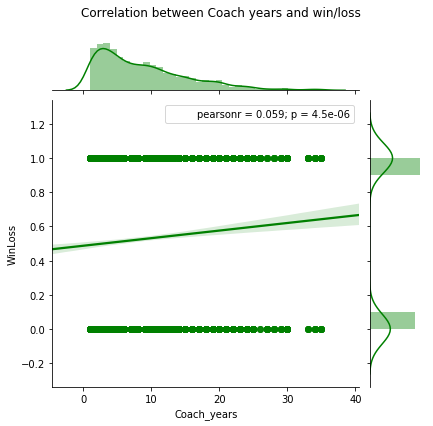

In [18]:
g = sns.jointplot(data=games, x='Coach_years', y='WinLoss', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between Coach years and win/loss') # can also get the figure from plt.gcf()
plt.show()

As seen in the chart above there is a slight correlation between the number of years you have coached and the likelihood of winning the game.  Interestingly, the correlation here (.06) is pretty small so just coaching longer doesn't mean you're going to win more games.

# Correlation between coaching win percent and win/losses of games

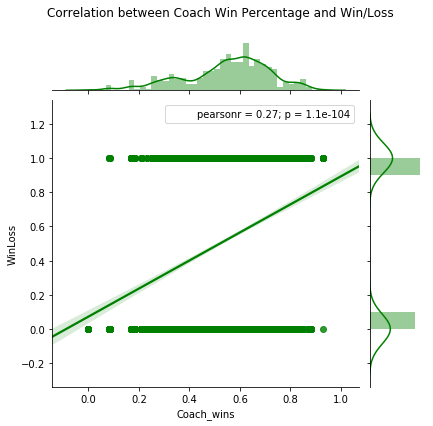

In [19]:
g = sns.jointplot(data=games, x='Coach_wins', y='WinLoss', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between Coach Win Percentage and Win/Loss') # can also get the figure from plt.gcf()
plt.show()

The results here indicate that there is a moderate correlation between a coaches win/loss percentage and the likelihood of winning any game they are involved with.  With a correlation of .27 this is a medium size effect so it's something you have to take into consideration. 

# Relationship between coaching win percentage and school win percentage

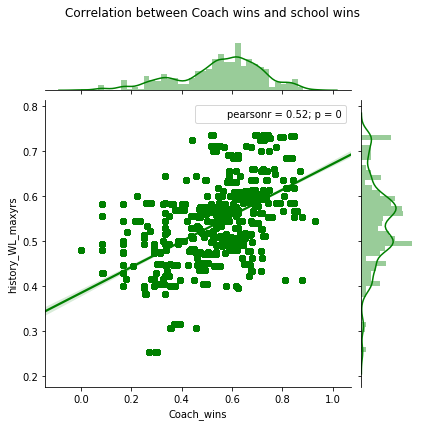

In [28]:
g = sns.jointplot(data=games, x='Coach_wins', y='history_WL_maxyrs', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between Coach wins and school wins') # can also get the figure from plt.gcf()
plt.show()

I think that these results are pretty interesting.  They indicate that there is a pretty strong relationship between a coaches win/loss percentage and the history of the school. Most coaches mirror the average win/loss ratio of the entire history of the school.  

# Relationship between coaching win percentage and coaching years 

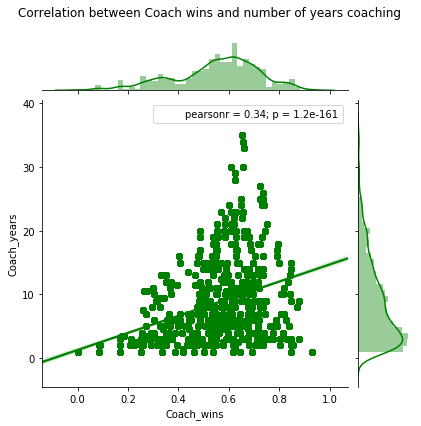

In [30]:
g = sns.jointplot(data=games, x='Coach_wins', y='Coach_years', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between Coach wins and number of years coaching') # can also get the figure from plt.gcf()
plt.show()
plt.show()


In [51]:
games.Coach_wins.median()

0.5784444444444445

Results here indicate there is a correlation between how long a coach has been coaching and their overall win percentage.  If we look at the median it's .578 wins. Looking off the graph, it looks like coaches who make it past 20 years tend to have higher win percentages. if you look at the extreme scores of 30+ years, those are all over the median.  Coaches who win a lot of games can stay in the business for a long time, those who don't win a lot don't make it 20-30 years easily. 

# Do offensive penalties matter? 

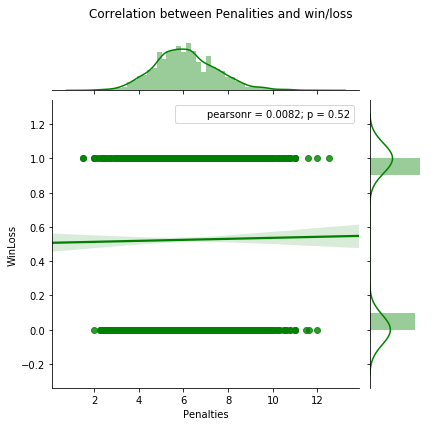

In [36]:
g = sns.jointplot(data=games, x='Penalties', y='WinLoss', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between Penalities and win/loss') 
plt.show()

There is actually a small positive correlation, such that those who win games tend to have slightly more penalties.  

# Correlation between sacks and wins/losses

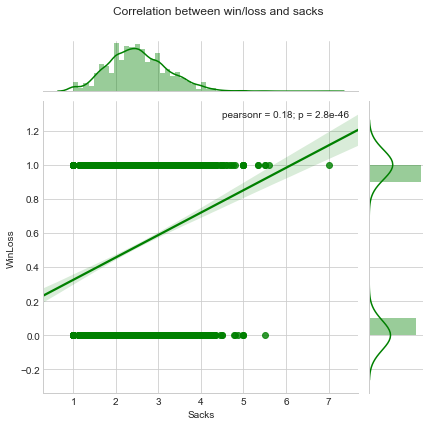

In [52]:
g = sns.jointplot(data=games, x='Sacks', y='WinLoss', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation between win/loss and sacks') 
plt.show()

Results here show there is a small correlation between the number of sacks and winning.  Those with more sacks tend to win.  Perhaps more aggresive style defenses win more games.

# In the day of up tempo offenses, do the number of plays make a difference for winning?

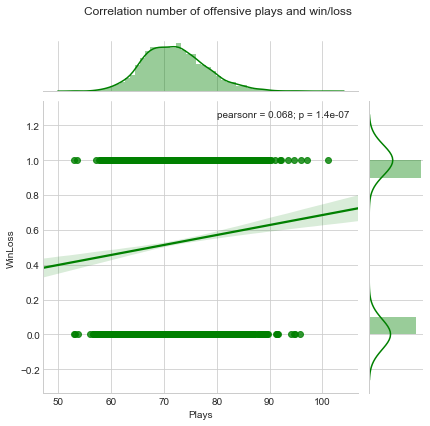

In [53]:
g = sns.jointplot(data=games, x='Plays', y='WinLoss', kind='reg', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation number of offensive plays and win/loss') 
plt.show()

There is a small positive correlation with more plays leading to more wins.  The correlation here isn't huge though.

# Does the number of defensive rushing yards given up make a difference in wins and losses?

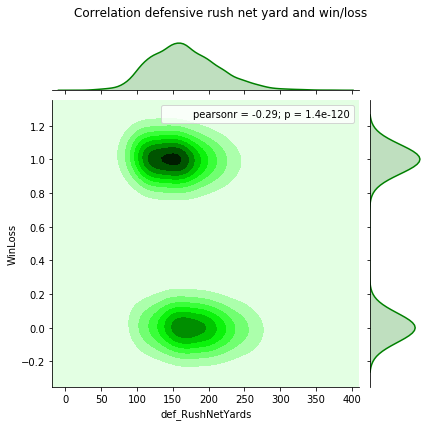

In [37]:
g= sns.jointplot(data=games, x='def_RushNetYards', y='WinLoss', kind='kde', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation defensive rush net yard and win/loss') 
plt.show()

Results here show that there is a negative correlation.  The fewer yards given up the more likely you are to win.  Using a kernal density plot, we can see there is a very dense population of around 150-180 yards or so given up for teams that win.  

# Is there a relationship between passing yards given up and winning?

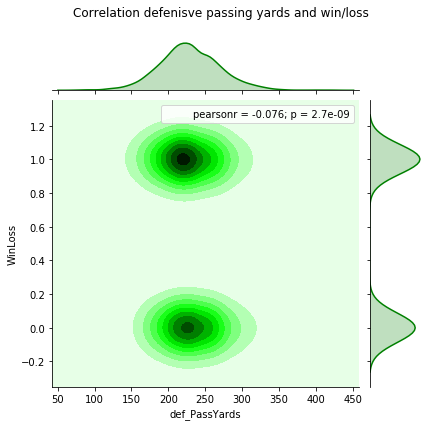

In [39]:
g = sns.jointplot(data=games, x='def_PassYards', y='WinLoss', kind='kde', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation defenisve passing yards and win/loss') 
plt.show()

Again, there is a slight negative correlation with winning teams giving up fewer passing yards.  However, if you look at the KDE plot you'll see that there is a lot of overlap between the graphs.  It seems like winning teams clamp down on the rushing yards and passing yards are roughly the same for winning/losing teams.  

# Is there a relationship between passes defended and winning games?

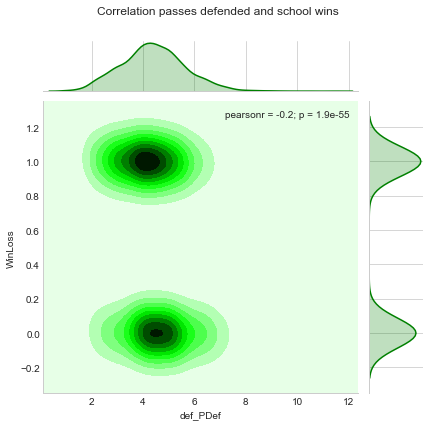

In [62]:
g = sns.jointplot(data=games, x='def_PDef', y='WinLoss', kind='kde', color='g')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation passes defended and school wins') 
plt.show()

Similar to previous results we again get a negative correlations with winning teams having more passes defended.  If you look at the KDE plot the number of pased defended is also much larger.  This could be because they are a more aggresive defense or simply because teams that are losing are forced to pass at the end of the game.  

# Quick look to see what the correlation between coaching percentage, historical wins at a school, and winning and losing a game. 

Results show they are all positively related. Coaches with higher win percentages work at schools with higher win percentages, and are more likely to win games.

In [57]:
print(games[['Coach_wins', 'history_WL_maxyrs', 'WinLoss']].corr())

                   Coach_wins  history_WL_maxyrs   WinLoss
Coach_wins           1.000000           0.520796  0.273745
history_WL_maxyrs    0.520796           1.000000  0.214389
WinLoss              0.273745           0.214389  1.000000


# Further exploration into coaching win percentages

As seen in the graph, most coaches are around .6.  There is a definite drop off of coaches who win more than .7 games and very few who win .8 or more.  

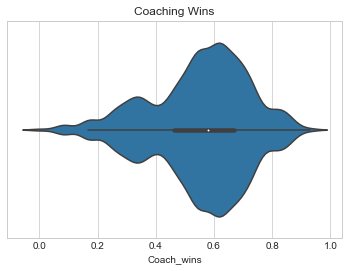

In [63]:
sns.set_style("whitegrid")
g = sns.violinplot(x="Coach_wins", data=games).set_title("Coaching Wins")
plt.show()

# Violin plot of rushing net yards and win/loss

Results here show a pretty distinctive difference betwene those who win and those who don't.  

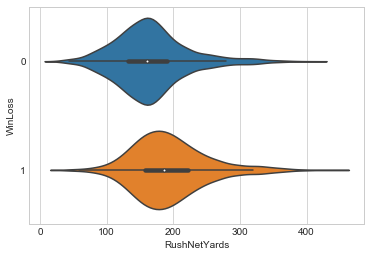

In [65]:
sns.violinplot(y="WinLoss", x="RushNetYards", data=games, orient='h')
plt.show()

# Win/loss and passing yards

Again, passing yards seems to be the "dog that didn't bark."  Teams who win and teams who lose seem to have really similar distributions.

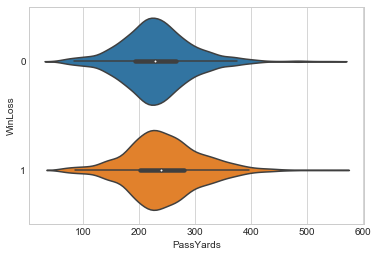

In [41]:
sns.violinplot(y="WinLoss", x="PassYards", data=games, orient='h')
plt.show()

# What are the relationships between passing yards and net rushing yards?

Results here show that there is a negative relationship, which makes sense.  Based on the previous results I think I'd pick to be a rush heavy team rather than a pass heavy team. 

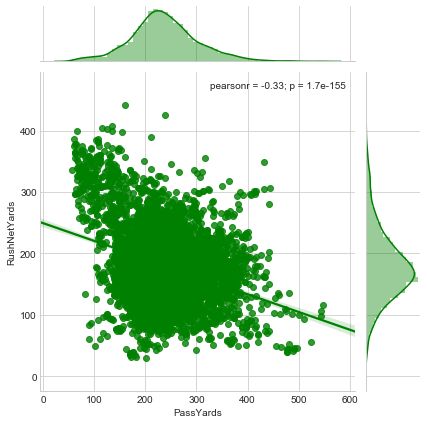

In [87]:
sns.jointplot(data=games, x='PassYards', y='RushNetYards', kind='reg', color='g')
plt.show()

# Final notes

The results here were really just scratching the surface of several of the variables I'm most interested in including in my analyses.  The difficulty is really the large number of variable that are available for anaysis and exploration.  